### <span style="color:#20B2AA"> Máster en Tecnologías de Análisis de Datos Masivos: Big Data
***
Tecnologías de gestión de información no estructurada                                                                   <br>
Profesor: David Enrique Losada Carril                                                                                   <br>
Práctica 2                                                                                                              <br>
<br>
Alumna: Irlui Ramírez Hernández                                                                                           <br>
16/12/2022                                                                                                                <br> 
******* 

In [303]:
import twint
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [304]:
import pandas as pd
import numpy as np
import dicttoxml 
from dicttoxml import dicttoxml
from dict2xml import dict2xml
from xml.dom.minidom import parseString
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import re
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
    
import nest_asyncio
import joblib
from matplotlib import pyplot as plt
stopwords = nltk.corpus.stopwords.words("english")

### Funciones generales

#### <span style="color:#20B2AA">  Definimos una función de recuperación de tweets.   <br>

***

In [305]:
#Definimos una función de recuperación de tweets.

def recupera_tweet (user):
    nest_asyncio.apply()
    c = twint.Config()
    c.Username = user
    c.Limit = 1000
    c.Pandas = True
    return c

***
####  <span style="color:#20B2AA"> Funciones de tratamiento de los datos: limpieza  <br>
***

In [306]:
# Fijación de párametros para la limpieza de los datos obtenidos. 
# Eliminamos url's, símbolos cómo @, prefijos y números como primer tratamiento de los datos 
# Usamos la librería y funciones de re.sub("cadena a buscar", "con la que se reemplaza", cadena_leida)
url = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
       '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
menciones = '@[\w\-]+'
hashtag = '#[\w\-]+'
caracteres_especiales = r'\W'
caracter_individual=r'\s+[a-zA-Z]\s+'
caracter_individual_inicio= r'\^[a-zA-Z]\s+'
varios_espacios= r'\s+'
prefijo_b = r'^b\s+'
numeros = '[0-9]+'

# Limpia y alamacena en una lista el nuevo corpus a partir de limpieza de los datos erróneos o innecesarios
def clean (corpus):
    corpus_ = []
    for coment in corpus:
        corpus_clean = coment.lower()  #Convertir a minúsculas
        corpus_clean = re.sub(menciones, ' ', coment)
        corpus_clean = re.sub(hashtag, ' ', corpus_clean)
        corpus_clean = re.sub(url, ' ', corpus_clean)
        corpus_clean = re.sub(caracteres_especiales, ' ', corpus_clean)
        corpus_clean = re.sub(caracter_individual, ' ', corpus_clean)
        corpus_clean = re.sub(caracter_individual_inicio, ' ', corpus_clean) 
        corpus_clean = re.sub(prefijo_b, '', corpus_clean)
        corpus_clean = re.sub(numeros, ' ', corpus_clean)
        corpus_clean = re.sub(" rt | amp ", ' ', corpus_clean)
        corpus_clean = re.sub(" q ", ' que ', corpus_clean)
        corpus_clean = re.sub(" sr ", ' señor ', corpus_clean)
        corpus_clean = re.sub(" x ", ' por ', corpus_clean)
        corpus_clean = re.sub(" d ", ' de ', corpus_clean)
        corpus_clean = re.sub(" xq ", ' porque ', corpus_clean)
        corpus_clean = re.sub(" eliminado ", ' ', corpus_clean)
        corpus_clean = re.sub(varios_espacios, ' ', corpus_clean, flags=re.I)
        corpus_.append(corpus_clean)   
    return corpus_

# Devuelve una lista con los documentos del corpus.

***
####  <span style="color:#20B2AA"> Orden y asignación de clase a cada personalidad<br>
***

In [307]:
# Crea un lista con cada tweet del dataFrame del personaje para luego limpiar los documentos del corpus.
def obtener_lista(df):
    corpus = []
    for text in df['tweet']:
        corpus.append(str(text))
    return corpus

# Crea el dataFrame nuevo con el tweet y la clase de cada personaje para luego unir al corpus general de cada par de personajes 
def corpus_clase(df,clase):
    corpus = obtener_lista(df) # Generar la lista
    corpus = clean(corpus)     # Limpiar los tweets de la lista para llenar el corpus
    df_corpus = pd.DataFrame(columns=["tweet","clase"])   # Crear el dataFrame del corpus y asigna la clase al que pertenece el conjunto de tweets
    for i in range(len(corpus)): 
        df_corpus.loc[i,['tweet']] = corpus[i]
    df_corpus.loc[:,['clase']] = clase
    return df_corpus  
# Retornamos el dataframe tweet - clase

### * <span style="color:#20B2AA"> Tokenización de tweets por personaje <br>
    
***
* Paso1: <span style="color:#20B2AA">  Separar los datos de cada personaje en entrenamiento 70% y test 30% <br>
* <span style="color:#000000">Paso 2: <span style="color:#20B2AA"> Configurar el objeto Vectorizer y extraer una representación “bag of words” de la colección para los datos de Train y Test por separado.<span style="color:#20B2AA">   <br>
* <span style="color:#000000">Paso 3: <span style="color:#20B2AA">  Listar los términos centrales del corpus de cada conjunto de personalidades  <br>
    
***

In [308]:
SEED_VALUE = 1 #semilla fija para todos los experimentos 
def dividir_set (corpus_user):
    user_train, user_test = train_test_split(corpus_user, 
                                             test_size=0.3, # Definimos el 30% del conjunto de datos para test
                                             random_state=SEED_VALUE)
    return(user_train, user_test)

def vectorizer ():
    # Configuramos las características del objeto Vectorizer que nos permitirá generar el modelo
    vectorizer_t = TfidfVectorizer(
        ngram_range=(1, 3),    #analiza hasta 3 palabras juntas
        stop_words=stopwords,  #para las palabras muy comunes propias del lenguaje que no contribuyen en el análisis 
        max_features=5000,     #Cantidad de palabras de mayor Tf/Idf que se requiere obtener para construir el modelo (que debe aprender)
        min_df=3,              #La característica debe aparecer en el 70% de los documentos
        max_df=0.80,           #Cantidad de documentos que deben contener el término o característica, en este caso el 90%.
        sublinear_tf=True,
        analyzer='word'
        )
    return(vectorizer_t)

    # Crear la matríz de DxN - Tokenizar y construir el vocabulario a partir de los documentos del corpus de cada conjunto de personalidades.
def matriz(corpus_user, persona1, persona2):
    matrizVectorizer = vectorizer()
    matrizV = matrizVectorizer.fit_transform(corpus_user)
    print("MATRIZ DE DOCUMENTOS X CARACTERÍSTICA PARA", persona1, " Y ", persona2)
    print(matrizV.toarray(), matrizV.shape)
    matrizV = matrizV.toarray()
    return (matrizV, matrizVectorizer)

    # Listamos los términos relevantes de la colección, en este caso el corpus de cada conjunto de personalidades.
def terminos (corpus_user):
    wordVectorizer = vectorizer()
    word = wordVectorizer.fit(corpus_user)
    termsDf = pd.DataFrame(word.get_feature_names_out(), columns=['Términos más centrales'])
    print(termsDf)

### * <span style="color:#20B2AA"> Clasificador de Tweets <br>
    
***
* Paso1: <span style="color:#20B2AA"> Creamos el clasificador de Tweets.  <br>
  En este caso, la experimentación la realizaremos con el método de clasificación de 2 clases: Máquinas vectores de soporte <br>
  usando las funciones de la librería scikit-learn con "smv.SVC".  <br>
  Implementamos los Kernels = LINEAR, POLY y RBF con variaciones de C con el fin de determinar cuál sería el de mejor desempeño <br>
  para muestras con las características de las personalidades que se seleccionaron para los dos set de documentos.
    
***

In [309]:
def clasificador_tweet (X_train,Y_train,X_test, Y_test, persona1, persona2):
    for k in ("linear", "poly", "rbf"):                         #Recorremos los tipos de kernels para generar los resultados
        if k == "linear": c=0.1
        if k == "poly": c=100.
        if k == "rbf": c=10.
        print("\n -                                                                            -")
        print("\n                                Kernel:",k,"                                  -")
        for i in range(0,3,1):                                    # clf es el objeto a partir del clasificador que se implementa.
            if k == "poly": clf = svm.SVC(kernel=k,               #Diferenciamos para implementar el grado de polinomio a 3
                                          gamma=1, degree= 3, 
                                          C=c, 
                                          probability=True, 
                                          class_weight='balanced',  
                                          random_state=SEED_VALUE)
            else: clf = svm.SVC(kernel=k,                          #Implementamos para kernel lineal y RBF
                                gamma=1, C=c, 
                                probability=True,   
                                random_state=SEED_VALUE)
            clf.fit(X_train,Y_train)
            set_Ypredict = clf.predict(X_test)                      #Probamos la efectividad del clasificador con los documentos de test.
                                                                    #Pasamos al predit la matriz generada con los comuentos de test y las 
                                                                    #caracteríticas (términos) centrales determinados para el conjunto de train.
            set_acuracy = (round((100 * accuracy_score(Y_test, set_Ypredict)),2)) #Métrica para medir la efectividad en la predicción de los tweets de test.
            
            #Imprimimos resultados por kernels y las variaciones del hiperparámetro de regularización C.
            print("\n -                                                                                -")
            print("\n                                Experimentación Nº: ",i,"                         -")
            print("\n Experiementación con el modelo SVC y Kernel = ", k, "con valor de C=",c)
            print("\n         Valor de accuracy de ",k," = ",
                  set_acuracy,"% de las predicciones de tweet son correctas")
            print("\n         Total de aciertos de ",k,"=" ,accuracy_score(Y_test, set_Ypredict, normalize=False))
            print("\n         Matríz de confusión para ",k,"para el set1 de clases 1 = ",persona1, " 2 = ", persona2)
            display("Resultados del clasificador:",pd.crosstab(Y_test, set_Ypredict, rownames=['Clase observación'], colnames=['Clase predicha']))
            cm = confusion_matrix(Y_test, set_Ypredict, labels=clf.classes_) #Generamos la matríz de confusión para cada
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,               #etiqueta del conjunto de documentos del corpus 
                                          display_labels=clf.classes_)
            disp.plot()        #Generamos y graficamos la matríz de confusión para ver el desepempeño del kernel del clasificador
            plt.show()
            c = c*10 #Incremenetamos para variar el hiperparámetro C del kernel del clasificador para evaluar las precisiones
                    #del clasificador

# Recuperación de tweet y obtencións datos.

###### <span style="color:#20B2AA">  Recuperamos los tweets de:
Dos hermanos: JonathanScott y MrDrewScott del programa televisivo Property Brother                                <br>
Dos personalidades no relacionadas: CakeBossBuddy y VancityReynolds.                                               <br>
Todos Norteamericanos y/o habla inglesa. 
***

In [310]:
#Definimos las variables para cada personalidad
jon_user = 'JonathanScott'
jon_clase = 1
drew_user = 'MrDrewScott'
drew_clase = 2
cake_user = 'CakeBossBuddy'
cake_clase = 3
rey_user = 'VancityReynolds'
rey_clase = 4

****
* Paso1: <span style="color:#20B2AA">  Mediante la función de recuperación "twint" obtenemos una colección de documentos de cada personalidad y los almacenamos en un dataframe <br>
    
***

In [9]:
#PASO1: Recuperamos de Jonathan Scott
jon = twint.run.Search(recupera_tweet(jon_user))
df_jon = twint.storage.panda.Tweets_df #Generamos el DataFrame de Jhonatan Scott

#PASO2: Tratamiento de tweets de Jonathan Scott - Conformamos el corpus con tweet y asignamos la clase correspondiente
corpus_jon = corpus_clase(df_jon, jon_clase)  

1600932001166594050 2022-12-08 20:15:07 +0100 <JonathanScott> Is it just me or is Jovie really cute? 🥰🎄  https://t.co/uEsxL0e7s4
1600890596432150530 2022-12-08 17:30:35 +0100 <JonathanScott> Can't wait! Who's tuning in this weekend? 😄🎄
1600728948622491648 2022-12-08 06:48:16 +0100 <JonathanScott> Absolutely.  But would you install a guinea pig dining room?
1600532111525818368 2022-12-07 17:46:06 +0100 <JonathanScott> Starting the new year on the right foot! Can't wait 😄🙌 #TeamJonathan
1599584728801476608 2022-12-05 03:01:32 +0100 <JonathanScott> @TheTedAllen I will address you as The Great One from this point forward!! 😋
1598743521611374592 2022-12-02 19:18:53 +0100 <JonathanScott> I haven’t been this excited about a movie in years! 😄
1596274993910145025 2022-11-25 23:49:50 +0100 <JonathanScott> @karengillan Ha! It’s the little things 🤣
1595980341151338498 2022-11-25 04:18:59 +0100 <JonathanScott> Who are you thankful for? I’m thankful for family, friends, supporters…but most important

In [10]:
#PASO1: Recuperamos de Drew Scott
drew = twint.run.Search(recupera_tweet(drew_user))
df_drew = twint.storage.panda.Tweets_df #Generamos el DataFrame de Drew Scott

#PASO2: Tratamiento de tweets de Drew Scott - Conformamos el corpus con tweet y asignamos la clase correspondiente
corpus_drew = corpus_clase(df_drew, drew_clase)  

1600535706568310784 2022-12-07 18:00:23 +0100 <MrDrewScott> Brother Vs Brother is BACK! Jonathan thinks he’ll take the title back but I have a few secrets up my sleeve💪🏡
1600532510521413632 2022-12-07 17:47:41 +0100 <MrDrewScott> @PropertyBrother @hgtv @JonathanScott #TeamDrew all the way! 😆🙌
1592195623427575808 2022-11-14 17:39:52 +0100 <MrDrewScott> We hope you’ll join us tonight on #CelebIOU to celebrate and pay tribute to our late friend Leslie Jordan, one of the kindest and most joyful people we had the pleasure to know.  https://t.co/jnTQidLZ1V
1587139438810832897 2022-10-31 18:48:24 +0100 <MrDrewScott> Which is cuter… Pumpkin Drew or pumpkin Parker? Wait, don’t answer that 🤣🎃❤️ #HappyHalloween  https://t.co/Av5NsWQ2yq
1585301848574988288 2022-10-26 18:06:28 +0100 <MrDrewScott> THIS is how excited I am about the Season 7 premiere of Property Brothers: #ForeverHome tonight  https://t.co/PmayHCpfaE
1584962189018161153 2022-10-25 19:36:47 +0100 <MrDrewScott> #HappyBirthday to my bea

In [11]:
#PASO1: Recuperamos de Carlos Cake Boss
cake = twint.run.Search(recupera_tweet(cake_user))
df_cake = twint.storage.panda.Tweets_df #Generamos el DataFrame de Cake

#PASO2: Tratamiento de tweets de Cake- Conformamos el corpus con tweet y asignamos la clase correspondiente
corpus_cake = corpus_clase(df_cake, cake_clase)  

1600313341947179009 2022-12-07 03:16:47 +0100 <CakeBossBuddy> Spent the afternoon in Delaware with the @wawa team and presented a custom @carlosbakery cake to #WallyGoose to celebrate their 30 years of shared ownership. I love when we can partner with companies that share our commitment to famiglia!  #cakeboss #carlosbakery #wawa  https://t.co/0HaRHdTKbF
1598801834780631065 2022-12-02 23:10:36 +0100 <CakeBossBuddy> Something is in the works at @carlosbakery Stay tuned to see what me and the famiglia have coming up! 🧑‍🍳  https://t.co/er2N3KsGhE
1589367583979208704 2022-11-06 22:22:15 +0100 <CakeBossBuddy> GONE FISHIN  🎣  https://t.co/KDk8AGE9J9
1577828079120048128 2022-10-06 03:08:23 +0100 <CakeBossBuddy> Flying high with the famiglia! Loved spending time with my family in #vegas. We took a break from working and experienced @flylinq at @thelinq and had a blast at the only zip line on #thestrip   #funinvegas #famiglia #vegasstrip #jerseyeats #bosscafe #pizzacake #buddyvs  https://t.co/u

In [12]:
#PASO1: Recuperamos de Vancity Reynolds
rey = twint.run.Search(recupera_tweet(rey_user))
df_rey = twint.storage.panda.Tweets_df #Generamos el DataFrame de Rey

#PASO2: Tratamiento de tweets de Rey - Conformamos el corpus con tweet y asignamos la clase correspondiente
corpus_rey = corpus_clase(df_rey, rey_clase)  

1601570623566008325 2022-12-10 14:32:47 +0100 <VancityReynolds>  https://t.co/PCIgjrBm16
1601545421662621696 2022-12-10 12:52:38 +0100 <VancityReynolds> @theblcklst ❤️❤️❤️
1601255543292981248 2022-12-09 17:40:46 +0100 <VancityReynolds> @welshy1000 @RMcElhenney I only know how to make an Aviation Gin with a splash of Aviation Gin.   Thanks for letting us crash, @welshy1000 ❤️🏴󠁧󠁢󠁷󠁬󠁳󠁿
1601212435947352064 2022-12-09 14:49:28 +0100 <VancityReynolds> Welcome to Wrexham Season 2: Charles in Charge.  https://t.co/TrwPkIMCzX
1600953907890782209 2022-12-08 21:42:10 +0100 <VancityReynolds> Here we go. ⚔️🏴󠁧󠁢󠁷󠁬󠁳󠁿⚔️
1600871675041845248 2022-12-08 16:15:24 +0100 <VancityReynolds> @JillKrop @BCCHF ⬆️⬆️⬆️⬆️❤️
1600862286339416064 2022-12-08 15:38:06 +0100 <VancityReynolds> And massive thanks to @AM34 who’s not only a legend in the NHL, but a legend in the halls of @sickkids 💙
1600861948421472256 2022-12-08 15:36:45 +0100 <VancityReynolds> Thank you to the one and only @Sethrogen for the assist!
16008619

****
* <span style="color:#000000">Paso 2: <span style="color:#20B2AA"> Conformamos el corpus de tweets y asignamos la clase correspondiente texto del tweet recuperado para cada personaje <br>
* <span style="color:#000000">Paso 3: <span style="color:#20B2AA"> Creamos los dos conjuntos de datos (por pareja de personajes) para crear el clasificador de tweets <br>
    
***

In [311]:
# PASO 3: Creamos los dos grupos o conjuntos de datos con los que se creará el clasificador de tweets

# SET 1: Jhon y Drew Scott
set1 = pd.concat([corpus_jon, corpus_drew])
display(set1.head(3))

# SET 2: Cake Boss y Reynolds
set2 = pd.concat([corpus_cake, corpus_rey])
display(set2.head(3))

#Guardamos el dataframe para su posterior procesamiento en un archivo local .csv

# set1.to_csv("C:/Users/Irlui ma/OneDrive - Universidade de Santiago de Compostela/Documentos/Máster BD USC/TGINE/2da_practica/twint/data/set1.csv")
# set2.to_csv("C:/Users/Irlui ma/OneDrive - Universidade de Santiago de Compostela/Documentos/Máster BD USC/TGINE/2da_practica/twint/data/set2.csv")
# dataset.to_csv("C:/Users/Irlui ma/OneDrive - Universidade de Santiago de Compostela/Documentos/Máster BD USC/TGINE/2da_practica/twint/data/tweets.csv")

set1.to_csv("C:/Users/usuario/OneDrive - Universidade de Santiago de Compostela/Documentos/Máster BD USC/TGINE/2da_practica/twint/data/set1.csv")
set2.to_csv("C:/Users/usuario/OneDrive - Universidade de Santiago de Compostela/Documentos/Máster BD USC/TGINE/2da_practica/twint/data/set2.csv")


,tweet,clase
0,Is it just me or is Jovie really cute,1
1,Can wait Who tuning in this weekend,1
2,Absolutely But would you install guinea pig di...,1


,tweet,clase
0,Spent the afternoon in Delaware with the team ...,3
1,Something is in the works at Stay tuned to see...,3
2,GONE FISHIN,3


# Conjuntos de entrenamiento y test para la experimentación.

****
* Paso1: <span style="color:#20B2AA">  Dividimos cada set de datos (cada pareja de personajes) en 70% train y 30% test y separamos variables de entrada y variable de salida<br>
* <span style="color:#000000">Paso 2: <span style="color:#20B2AA"> Extraemos las características, el set de "Features in Bag of Words" para train y para test<br>
* <span style="color:#000000">Paso 3: <span style="color:#20B2AA">Generamos la matriz D x T <br>
    
***

In [312]:
# PASO 1
# Dividimos en train y test
# Set_1 - Jhon y Drew
set1_train, set1_test = dividir_set(set1)

# Set_2 - CakeBoss y Reynolds
set2_train, set2_test = dividir_set(set2)

set2_train, set2_test, set1_train, set1_test

(                                                 tweet clase
 194                                                        4
 45   Good times at the game today Staying Golden fo...     3
 477                                     Well done Ava      4
 293                             There can be only one      4
 736   Bring lighter flask flashlight knife glow sti...     4
 ..                                                 ...   ...
 791   m still not sure about the fox Everything els...     4
 96                                                         4
 932  I was lucky to know Jamie was lucky to laugh w...     4
 235  Hope everyone enjoyed the first episode of che...     3
 61                                                         4
 
 [1400 rows x 2 columns],
                                                  tweet clase
 674  Gathering lots of inspiration wait to you see ...     3
 699   BRB Just gonna duct tape my phone to my face ...     4
 282                                      

In [313]:
# Separamos variables de entrada y variables de salida
set1_train_X = set1_train['tweet']
set1_train_Y = set1_train['clase']
set1_test_X = set1_test['tweet']
set1_test_Y = set1_test['clase']

set2_train_X = set2_train['tweet']
set2_train_Y = set2_train['clase']
set2_test_X = set2_test['tweet']
set2_test_Y = set2_test['clase']


set1_train_Y = set1_train_Y.astype('int')
set1_test_Y = set1_test_Y.astype('int')
set2_train_Y = set2_train_Y.astype('int') 
set2_test_Y = set2_test_Y.astype('int')

print(set1_train_Y.shape, set1_test_Y.shape, set2_train_Y.shape, set2_test_Y.shape)

(1400,) (600,) (1400,) (600,)


****
*<span style="color:#20B2AA"> Sólo conjunto de TRAIN <br>
    Extraemos las características, el set de "Features in Bag of Words" para train<br>
    
***

In [314]:
# PASO 2 - TRAIN -  SET1 - X
# Extraemos las características (términos) de la colección
set1_terms = terminos(set1_train_X)

     Términos más centrales
0                      able
1                 able give
2                absolutely
3                  accounts
4                    across
...                     ...
1214                    yet
1215                  young
1216                youtube
1217        youtube channel
1218                  zooey

[1219 rows x 1 columns]


In [315]:
# PASO 3 - TRAIN -  SET1 - MATRIZ DE DOCUMENTOS X CARACTERÍSTICA - X
set1_train_matrizX, set1_vactorizer_train = matriz(set1_train_X, jon_user, drew_user) # Almacena el vectorizer de train para pasarlo a la matriz de test

MATRIZ DE DOCUMENTOS X CARACTERÍSTICA PARA JonathanScott  Y  MrDrewScott
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (1400, 1219)


In [316]:
# PASO 2 - TRAIN -  SET2 - X
# Extraemos las características (términos) de la colección del SET2
set2_terms = terminos(set2_train_X)

    Términos más centrales
0                     able
1                 accident
2                   actual
3                 actually
4                       ad
..                     ...
872                    yet
873                   york
874                  young
875                    yup
876                   zero

[877 rows x 1 columns]


In [317]:
# PASO 3 - TRAIN -  SET2 - MATRIZ DE DOCUMENTOS X CARACTERÍSTICA - X
set2_train_matrizX, set2_vactorizer_train = matriz(set2_train_X, cake_user, rey_user) # Almacena el vectorizer de train para pasarlo a la matriz de test

MATRIZ DE DOCUMENTOS X CARACTERÍSTICA PARA CakeBossBuddy  Y  VancityReynolds
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (1400, 877)


****
*<span style="color:#20B2AA"> Sólo conjunto de TEST <br>
    Extraemos las características, el set de "Features in Bag of Words" para test<br>
    
***

In [318]:
# PASO 2 - TEST -  SET1 - X
# Extraemos las características (términos) de la colección
set1_terms_test = terminos(set1_test_X)

    Términos más centrales
0                     able
1                   action
2                      add
3                    added
4                      ago
..                     ...
532                    yet
533                  young
534                youtube
535        youtube channel
536                  zooey

[537 rows x 1 columns]


In [319]:
# PASO 3 - TEST-  SET1 - MATRIZ  (set1_vactorizer_train es el vectorizer-objeto de train para el mismo set) - X
# MATRIZ DE DOCUMENTOS X CARACTERÍSTICA
set1_vec_testX = set1_vactorizer_train.transform(set1_test_X) #Caracteristicas a partir de los datos de test

# Entrenamos con el mismo vectorizer con el que se entrenaron los datos de Train para conseguir la matriz con la dimensión igual
# al tamaño de características obtenidos del conjunto de datos de train 

set1_vector_fit_testX = set1_vec_testX.toarray() #convertimos a numpy array y listamos
print(set1_vector_fit_testX, set1_vec_testX.shape, type(set1_vector_fit_testX))

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.50147937 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (600, 1219) <class 'numpy.ndarray'>


In [320]:
# PASO 2 - TEST -  SET2 - X
# Extraemos las características (términos) de la colección del SET2
set2_terms_test = terminos(set2_test_X)

    Términos más centrales
0                   across
1                 actually
2                       ad
3                   almost
4                    along
..                     ...
330                  would
331                    wow
332                   year
333                  years
334                    yes

[335 rows x 1 columns]


In [321]:
# PASO 3 - TEST -  SET2 - MATRIZ (set2_vactorizer_train es el vectorizer-objeto de train para el mismo set) X
# MATRIZ DE DOCUMENTOS X CARACTERÍSTICA
set2_vec_test = set2_vactorizer_train.transform(set2_test_X)

# Entrenamos con el mismo vectorizer con el que se entrenaron los datos de Train para conseguir la matriz con la dimensión igual
# al tamaño de características obtenidos del conjunto de datos de train 

set2_vector_fit_testX = set2_vec_test.toarray() #convertimos a numpy array y listamos
print(set2_vector_fit_testX, set2_vec_test.shape, type(set2_vector_fit_testX))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (600, 877) <class 'numpy.ndarray'>


# Experimentación con SVM

****
* Paso1: <span style="color:#20B2AA">  Instanciamos el clasificador para cada set
    
***


* *Empezamos con el SET1:* <span style="color:#20B2AA"> Dos hermanos: Jonathan Scott y MrDrew Scott del programa televisivo Property Brother                                <br>
    <br>
    * La colección de términos relevantes, para este set de personalidades, es muy similar, por ello al clasificador <br>
    le resulta más difícil determinar a quien pertenece un tweet (documento) de las muestras en test.              <br>
    
    * De la experimentación, se obtinen resultados entre el 51 y 63,5% de aciertos.                                    <br>
    
    * EL resultado más óptimo se alcanza con el clasificador creado con el SVC, kernel "Linear y C=1.0", alcanzando un <br>
    63,5% de aciertos en la predicción de la clase del tweet o documento para el corpus de este conjunto de personalidades.<br>
    
    * El desempeño del kernel poly es el más deficientes.
    
***


 -                                                                            -

                                Kernel: linear                                   -

 -                                                                                -

                                Experimentación Nº:  0                          -

 Experiementación con el modelo SVC y Kernel =  linear con valor de C= 0.1

         Valor de accuracy de  linear  =  56.67 % de las predicciones de tweet son correctas

         Total de aciertos de  linear = 340

         Matríz de confusión para  linear para el set1 de clases 1 =  JonathanScott  2 =  MrDrewScott


'Resultados del clasificador:'

Clase predicha,1,2
Clase observación,,
1,58,241
2,19,282


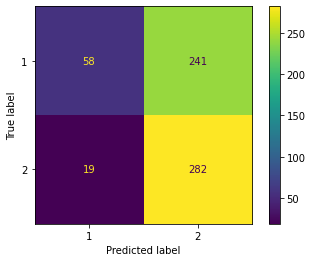


 -                                                                                -

                                Experimentación Nº:  1                          -

 Experiementación con el modelo SVC y Kernel =  linear con valor de C= 1.0

         Valor de accuracy de  linear  =  63.5 % de las predicciones de tweet son correctas

         Total de aciertos de  linear = 381

         Matríz de confusión para  linear para el set1 de clases 1 =  JonathanScott  2 =  MrDrewScott


'Resultados del clasificador:'

Clase predicha,1,2
Clase observación,,
1,180,119
2,100,201


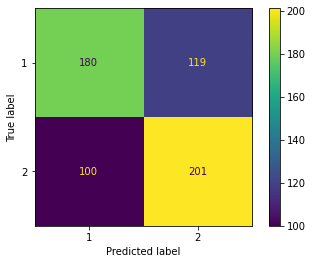


 -                                                                                -

                                Experimentación Nº:  2                          -

 Experiementación con el modelo SVC y Kernel =  linear con valor de C= 10.0

         Valor de accuracy de  linear  =  59.67 % de las predicciones de tweet son correctas

         Total de aciertos de  linear = 358

         Matríz de confusión para  linear para el set1 de clases 1 =  JonathanScott  2 =  MrDrewScott


'Resultados del clasificador:'

Clase predicha,1,2
Clase observación,,
1,181,118
2,124,177


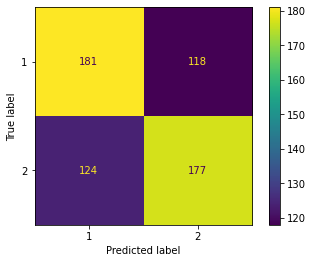


 -                                                                            -

                                Kernel: poly                                   -

 -                                                                                -

                                Experimentación Nº:  0                          -

 Experiementación con el modelo SVC y Kernel =  poly con valor de C= 100.0

         Valor de accuracy de  poly  =  51.67 % de las predicciones de tweet son correctas

         Total de aciertos de  poly = 310

         Matríz de confusión para  poly para el set1 de clases 1 =  JonathanScott  2 =  MrDrewScott


'Resultados del clasificador:'

Clase predicha,1,2
Clase observación,,
1,22,277
2,13,288


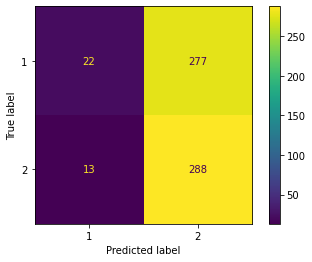


 -                                                                                -

                                Experimentación Nº:  1                          -

 Experiementación con el modelo SVC y Kernel =  poly con valor de C= 1000.0

         Valor de accuracy de  poly  =  51.67 % de las predicciones de tweet son correctas

         Total de aciertos de  poly = 310

         Matríz de confusión para  poly para el set1 de clases 1 =  JonathanScott  2 =  MrDrewScott


'Resultados del clasificador:'

Clase predicha,1,2
Clase observación,,
1,23,276
2,14,287


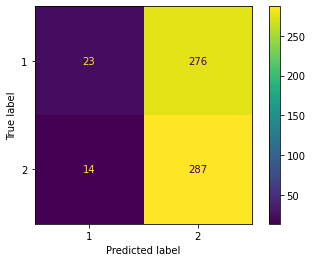


 -                                                                                -

                                Experimentación Nº:  2                          -

 Experiementación con el modelo SVC y Kernel =  poly con valor de C= 10000.0

         Valor de accuracy de  poly  =  51.67 % de las predicciones de tweet son correctas

         Total de aciertos de  poly = 310

         Matríz de confusión para  poly para el set1 de clases 1 =  JonathanScott  2 =  MrDrewScott


'Resultados del clasificador:'

Clase predicha,1,2
Clase observación,,
1,23,276
2,14,287


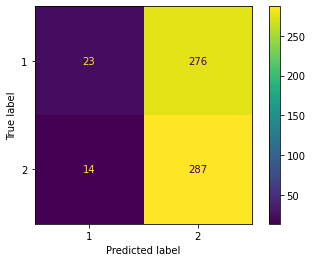


 -                                                                            -

                                Kernel: rbf                                   -

 -                                                                                -

                                Experimentación Nº:  0                          -

 Experiementación con el modelo SVC y Kernel =  rbf con valor de C= 10.0

         Valor de accuracy de  rbf  =  59.5 % de las predicciones de tweet son correctas

         Total de aciertos de  rbf = 357

         Matríz de confusión para  rbf para el set1 de clases 1 =  JonathanScott  2 =  MrDrewScott


'Resultados del clasificador:'

Clase predicha,1,2
Clase observación,,
1,181,118
2,125,176


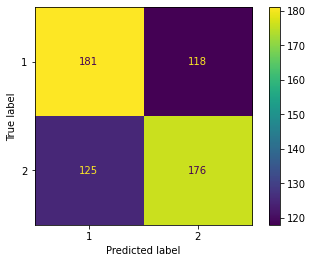


 -                                                                                -

                                Experimentación Nº:  1                          -

 Experiementación con el modelo SVC y Kernel =  rbf con valor de C= 100.0

         Valor de accuracy de  rbf  =  60.0 % de las predicciones de tweet son correctas

         Total de aciertos de  rbf = 360

         Matríz de confusión para  rbf para el set1 de clases 1 =  JonathanScott  2 =  MrDrewScott


'Resultados del clasificador:'

Clase predicha,1,2
Clase observación,,
1,181,118
2,122,179


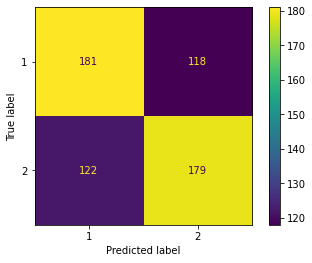


 -                                                                                -

                                Experimentación Nº:  2                          -

 Experiementación con el modelo SVC y Kernel =  rbf con valor de C= 1000.0

         Valor de accuracy de  rbf  =  59.67 % de las predicciones de tweet son correctas

         Total de aciertos de  rbf = 358

         Matríz de confusión para  rbf para el set1 de clases 1 =  JonathanScott  2 =  MrDrewScott


'Resultados del clasificador:'

Clase predicha,1,2
Clase observación,,
1,179,120
2,122,179


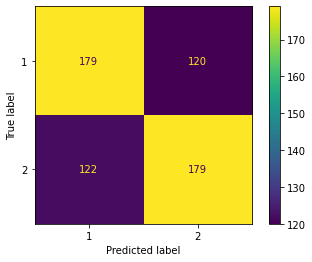

In [322]:
### INSTANCIAMOS: ejecutamos el clasificador de tweets para el set 1 Jonathan y MrDrew Scott

clasificador_tweet(set1_train_matrizX, set1_train_Y, set1_vector_fit_testX, set1_test_Y, jon_user, drew_user)

## * ________ ____ ______ ______________ _____________ __________ __________ 
***

* *Continuamos con el SET2:* <span style="color:#20B2AA"> Dos personalidades no relacionadas: CakeBossBuddy y VancityReynolds.                                 <br>
    <br>
    * La colección de términos relevantes, para este set de personalidades, es poco similar, por ello al clasificador: <br>
    
    * le resulta más fácil determinar a quien pertenece un tweet (documento) de las muestras en test.              <br>
    
    * De la experimentación, se obtinen resultados entre el 60 y 78% de aciertos.                                  <br>
    
    * El kernel poly tiene mejor desempeño con características más diferenciadas.                                  <br>
    
***


 -                                                                            -

                                Kernel: linear                                   -

 -                                                                                -

                                Experimentación Nº:  0                          -

 Experiementación con el modelo SVC y Kernel =  linear con valor de C= 0.1

         Valor de accuracy de  linear  =  74.83 % de las predicciones de tweet son correctas

         Total de aciertos de  linear = 449

         Matríz de confusión para  linear para el set1 de clases 1 =  CakeBossBuddy  2 =  VancityReynolds


'Resultados del clasificador:'

Clase predicha,3,4
Clase observación,,
3,172,127
4,24,277


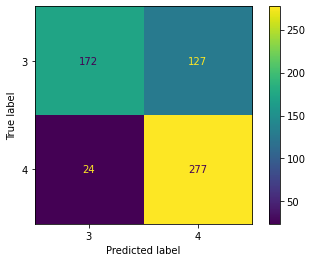


 -                                                                                -

                                Experimentación Nº:  1                          -

 Experiementación con el modelo SVC y Kernel =  linear con valor de C= 1.0

         Valor de accuracy de  linear  =  77.83 % de las predicciones de tweet son correctas

         Total de aciertos de  linear = 467

         Matríz de confusión para  linear para el set1 de clases 1 =  CakeBossBuddy  2 =  VancityReynolds


'Resultados del clasificador:'

Clase predicha,3,4
Clase observación,,
3,224,75
4,58,243


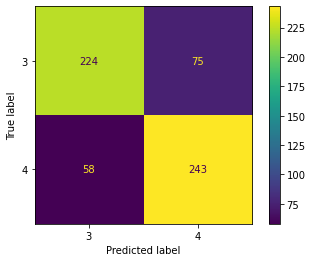


 -                                                                                -

                                Experimentación Nº:  2                          -

 Experiementación con el modelo SVC y Kernel =  linear con valor de C= 10.0

         Valor de accuracy de  linear  =  74.83 % de las predicciones de tweet son correctas

         Total de aciertos de  linear = 449

         Matríz de confusión para  linear para el set1 de clases 1 =  CakeBossBuddy  2 =  VancityReynolds


'Resultados del clasificador:'

Clase predicha,3,4
Clase observación,,
3,225,74
4,77,224


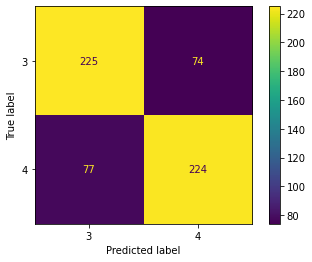


 -                                                                            -

                                Kernel: poly                                   -

 -                                                                                -

                                Experimentación Nº:  0                          -

 Experiementación con el modelo SVC y Kernel =  poly con valor de C= 100.0

         Valor de accuracy de  poly  =  59.17 % de las predicciones de tweet son correctas

         Total de aciertos de  poly = 355

         Matríz de confusión para  poly para el set1 de clases 1 =  CakeBossBuddy  2 =  VancityReynolds


'Resultados del clasificador:'

Clase predicha,3,4
Clase observación,,
3,73,226
4,19,282


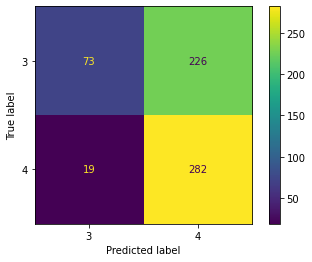


 -                                                                                -

                                Experimentación Nº:  1                          -

 Experiementación con el modelo SVC y Kernel =  poly con valor de C= 1000.0

         Valor de accuracy de  poly  =  59.17 % de las predicciones de tweet son correctas

         Total de aciertos de  poly = 355

         Matríz de confusión para  poly para el set1 de clases 1 =  CakeBossBuddy  2 =  VancityReynolds


'Resultados del clasificador:'

Clase predicha,3,4
Clase observación,,
3,73,226
4,19,282


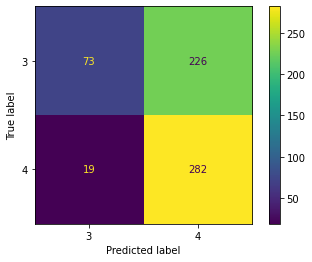


 -                                                                                -

                                Experimentación Nº:  2                          -

 Experiementación con el modelo SVC y Kernel =  poly con valor de C= 10000.0

         Valor de accuracy de  poly  =  59.17 % de las predicciones de tweet son correctas

         Total de aciertos de  poly = 355

         Matríz de confusión para  poly para el set1 de clases 1 =  CakeBossBuddy  2 =  VancityReynolds


'Resultados del clasificador:'

Clase predicha,3,4
Clase observación,,
3,73,226
4,19,282


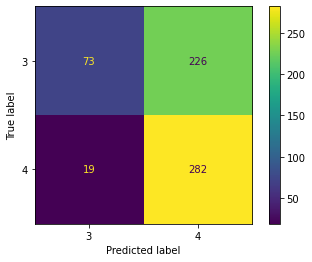


 -                                                                            -

                                Kernel: rbf                                   -

 -                                                                                -

                                Experimentación Nº:  0                          -

 Experiementación con el modelo SVC y Kernel =  rbf con valor de C= 10.0

         Valor de accuracy de  rbf  =  77.33 % de las predicciones de tweet son correctas

         Total de aciertos de  rbf = 464

         Matríz de confusión para  rbf para el set1 de clases 1 =  CakeBossBuddy  2 =  VancityReynolds


'Resultados del clasificador:'

Clase predicha,3,4
Clase observación,,
3,231,68
4,68,233


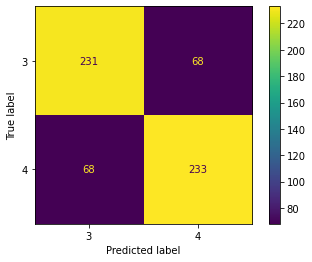


 -                                                                                -

                                Experimentación Nº:  1                          -

 Experiementación con el modelo SVC y Kernel =  rbf con valor de C= 100.0

         Valor de accuracy de  rbf  =  77.33 % de las predicciones de tweet son correctas

         Total de aciertos de  rbf = 464

         Matríz de confusión para  rbf para el set1 de clases 1 =  CakeBossBuddy  2 =  VancityReynolds


'Resultados del clasificador:'

Clase predicha,3,4
Clase observación,,
3,231,68
4,68,233


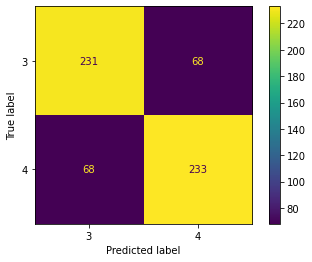


 -                                                                                -

                                Experimentación Nº:  2                          -

 Experiementación con el modelo SVC y Kernel =  rbf con valor de C= 1000.0

         Valor de accuracy de  rbf  =  77.83 % de las predicciones de tweet son correctas

         Total de aciertos de  rbf = 467

         Matríz de confusión para  rbf para el set1 de clases 1 =  CakeBossBuddy  2 =  VancityReynolds


'Resultados del clasificador:'

Clase predicha,3,4
Clase observación,,
3,230,69
4,64,237


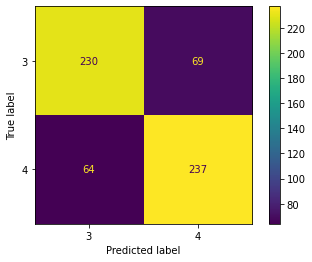

In [323]:
### INSTANCIAMOS: ejecutamos el clasificador de tweets para el set 2 Cake Boss (Carlos Budy Valastro) y Vancity Reynolds

clasificador_tweet(set2_train_matrizX, set2_train_Y, set2_vector_fit_testX, set2_test_Y, cake_user, rey_user)

### Ejercicio 2: (optativo) análisis básico de sentimiento. 
Utilizando VADER realizad un análisis básico del sentimiento de los tweets de cada uno de los personajes que habéis considerado.

***
### <span style="color:#20B2AA"> Cargamos la librería y objetos de VaderSentiment

In [324]:
!pip install vaderSentiment

In [325]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Funciones generales

In [326]:
#Implemantaremos el objeto analyzer de la librería VaderSentiment
analyzer = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

****
* Paso1: <span style="color:#20B2AA">  Tomamos los tweets para el corpus de todas las personalides. 
    
    * Cada set contiene 4000 tweets recuperados en cada colección.
    
***

In [327]:
dataset = pd.concat([set1,set2])
display(general)

,tweet,clase
0,Is it just me or is Jovie really cute,1
1,Can wait Who tuning in this weekend,1
2,Absolutely But would you install guinea pig di...,1
3,Starting the new year on the right foot Can wait,1
4,will address you as The Great One from this p...,1
...,...,...
995,Wait wha Donate to and we ll TRIPLE it,4
996,,4
997,,4
998,If you and friends lift Volkswagen Beatle and...,4


****
* Paso2: <span style="color:#20B2AA">  Asignar la puntuación sobre la polaridad del contenido del documento analizado mediante la función 
    analyzer.polarity_scores
    
    * Agregar la columna de valoración del documento.
    
***

In [328]:
# Con la implementación de lamda hacemos secuencial la aplicación del análisis a cada uno de los 2000 tweets
dataset["polaridad"] = dataset["tweet"].apply(lambda x: analyzer.polarity_scores(x)['compound'])
dataset

,tweet,clase,polaridad
0,Is it just me or is Jovie really cute,1,0.5095
1,Can wait Who tuning in this weekend,1,0.0000
2,Absolutely But would you install guinea pig di...,1,0.0000
3,Starting the new year on the right foot Can wait,1,0.0000
4,will address you as The Great One from this p...,1,0.6249
...,...,...,...
995,Wait wha Donate to and we ll TRIPLE it,4,0.0000
996,,4,0.0000
997,,4,0.0000
998,If you and friends lift Volkswagen Beatle and...,4,-0.0258


### * <span style="color:#20B2AA"> Con la metrica de la polaridad asignada a cada documento se van a categorizar cada uno:    <br>
   
    
***
* Paso1: <span style="color:#20B2AA">  Asignar etiqueta de sentimiento según categoría o rango.<br>
    
* <span style="color:#000000">Paso 2: <span style="color:#20B2AA"> Establecer rangos y etiqueta.
    
**  <span style="color:#20B2AA"> *  SENTIMIENTOS - ETIQUETAS  <br>
* <span style="color:#000000">* Positivo:(polaridad > = 0.05) <br>
* <span style="color:#000000">* Negativo:(polaridad < = -0.05) <br>   
* <span style="color:#000000">* Neutral:(-0.05 < polaridad < = 0.05) <br>

***

In [329]:
dataset["sentimiento"] = dataset["polaridad"].apply(lambda x: 'positivo' if x >= 0.05 else ('negativo' if x <= -0.05 else 'neutral'))
dataset

,tweet,clase,polaridad,sentimiento
0,Is it just me or is Jovie really cute,1,0.5095,positivo
1,Can wait Who tuning in this weekend,1,0.0000,neutral
2,Absolutely But would you install guinea pig di...,1,0.0000,neutral
3,Starting the new year on the right foot Can wait,1,0.0000,neutral
4,will address you as The Great One from this p...,1,0.6249,positivo
...,...,...,...,...
995,Wait wha Donate to and we ll TRIPLE it,4,0.0000,neutral
996,,4,0.0000,neutral
997,,4,0.0000,neutral
998,If you and friends lift Volkswagen Beatle and...,4,-0.0258,neutral


* <span style="color:#20B2AA"> A partir de estas etiquetas de sentimientos sobre la polaridad del documento,    <br>
podemos realizar análisis y gráficos de resultados.
   
    
* Paso1: <span style="color:#20B2AA">  Cuadro de valores a partir del objeto de la librería Vader score. Metricas por cada etiqueta y promedio general.<br>

***

In [330]:
scores =[]

for sentence in dataset["tweet"]:
    score = analyzer.polarity_scores(sentence)
    scores.append(score)
    
#Convertir el diccionario de datos en dataframe para visualizar los resultados por etiqueta para cada docuemento.
# Tenemos una 
dataFrame= pd.DataFrame(scores)

print(dataFrame)

print("Overall Sentiment Score for the multiple sentences :- ")
dataFrame.mean()

        neg    neu    pos  compound
0     0.000  0.708  0.292    0.5095
1     0.000  1.000  0.000    0.0000
2     0.000  1.000  0.000    0.0000
3     0.000  1.000  0.000    0.0000
4     0.000  0.709  0.291    0.6249
...     ...    ...    ...       ...
3995  0.000  1.000  0.000    0.0000
3996  0.000  0.000  0.000    0.0000
3997  0.000  0.000  0.000    0.0000
3998  0.113  0.777  0.110   -0.0258
3999  0.000  1.000  0.000    0.0000

[4000 rows x 4 columns]
Overall Sentiment Score for the multiple sentences :- 


neg         0.033407
neu         0.696794
pos         0.218796
compound    0.349828
dtype: float64

### * Paso1: <span style="color:#20B2AA">  Agrupar por etiqueta para para obtener los totales de categoría por documento:
***

In [331]:
set1_vader_categoría = dataset.groupby(dataset["sentimiento"])
set1_categorías_totales = pd.DataFrame(set1_vader_categoría.count().tweet)
set1_categorías_media = pd.DataFrame(set1_vader_categoría.mean())
set1_categorías_max = pd.DataFrame(set1_vader_categoría.max())
set1_categorías_min = pd.DataFrame(set1_vader_categoría.min())


display("Total de documentos por etiqueta de sentimiento",set1_categorías_totales.T)
display("Pomedio de valoracón de la polarización de documentos por etiqueta de sentimiento",set1_categorías_media.T)
display("Máximas valoraciones de la polarización de documentos por etiqueta de sentimiento",set1_categorías_max)
display("Mínimas valoraciones de la polarización de documentos por etiqueta de sentimiento",set1_categorías_min)
# La mayoría de los Tweet para el conjunto de documentos del corpus son positivos

'Total de documentos por etiqueta de sentimiento'

sentimiento,negativo,neutral,positivo
tweet,342,1215,2443


'Pomedio de valoracón de la polarización de documentos por etiqueta de sentimiento'

sentimiento,negativo,neutral,positivo
polaridad,-0.354353,0.000126,0.622328


'Máximas valoraciones de la polarización de documentos por etiqueta de sentimiento'

,tweet,clase,polaridad
sentimiento,,,
negativo,this is getting dangerous we have to figure so...,4,-0.0516
neutral,they call me the Forklift Boss think your onto...,4,0.0387
positivo,𝗛𝗔𝗣𝗣𝗬 𝗕𝗢𝗢𝗞 𝗕𝗜𝗥𝗧𝗛𝗗𝗔𝗬 to Better Together To add ...,4,0.9905


'Mínimas valoraciones de la polarización de documentos por etiqueta de sentimiento'

,tweet,clase,polaridad
sentimiento,,,
negativo,About years ago opted to purchase wind genera...,1,-0.9808
neutral,,1,-0.0258
positivo,Agree agree agree,1,0.0516


('JonathanScott', 'clase:', 1, 'MrDrewScott', 'clase:', 2, 'CakeBossBuddy', 'clase:', 3, 'VancityReynolds', 'clase:', 4)


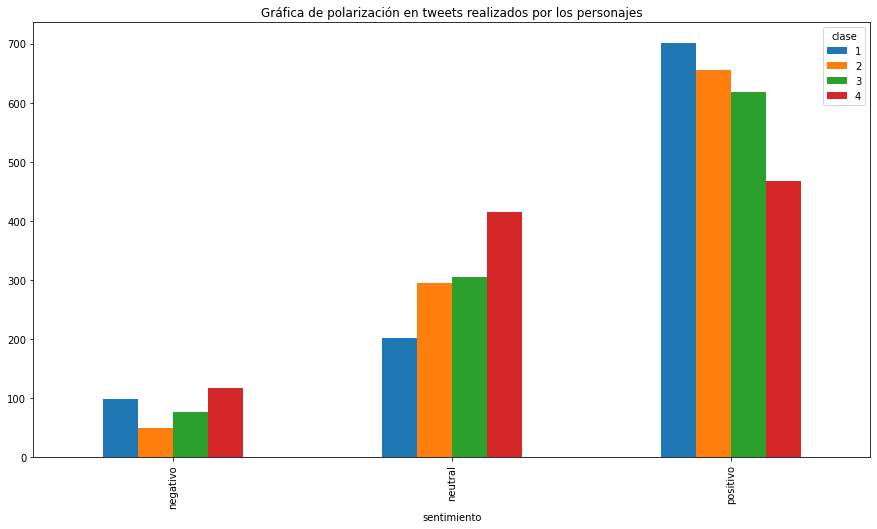

In [332]:
#Gráfica de etiqueta de sentimiento por personalidad.

lista = (jon_user,"clase:",jon_clase, drew_user,"clase:", drew_clase, cake_user, "clase:",cake_clase, rey_user, "clase:",rey_clase)
print(lista)
dataset.groupby([pd.Grouper(key='sentimiento'), "clase"]).size().unstack().plot(kind = "bar", title = "Gráfica de polarización en tweets realizados por los personajes", figsize = (15, 8))
plt.show()

#### * Análisis de sentimientos: <span style="color:#20B2AA">  Para concluir, la librería VaderSentiment 
    es muy práctica para el procesamiento de documentos de texto a los que se requiera categorizar por "sentimiento". 
    Con esta, de forma automática se implementan a través de sus objetos la comparación de cada término o característica del corpus de documentos, en este caso práctico construido a partir de tweets, con una lista de términos categorizados por 
    tipo de sentimiento. Estas categorías se asocian a etiquetas de "Negativo", "Neutral" y "Positivo" con la finalidad de 
    mostrar resultados, tendencias o valoraciones sobre un conjunto de personas o población de estudio.
***

In [333]:
# Anexos: Lista de variables implementadas:
%whos

Variable                     Type                          Data/Info
--------------------------------------------------------------------
ConfusionMatrixDisplay       type                          <class 'sklearn.metrics._<...>.ConfusionMatrixDisplay'>
CountVectorizer              type                          <class 'sklearn.feature_e<...>on.text.CountVectorizer'>
DictVectorizer               type                          <class 'sklearn.feature_e<...>ctorizer.DictVectorizer'>
Pipeline                     ABCMeta                       <class 'sklearn.pipeline.Pipeline'>
SEED_VALUE                   int                           1
SVC                          ABCMeta                       <class 'sklearn.svm._classes.SVC'>
SelectKBest                  ABCMeta                       <class 'sklearn.feature_s<...>e_selection.SelectKBest'>
SentimentIntensityAnalyzer   type                          <class 'vaderSentiment.va<...>timentIntensityAnalyzer'>
StandardScaler               type    